In [1]:
import io

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as st

In [2]:
plt.rcParams.update({
    "axes.prop_cycle": plt.cycler("color", ['#000000', '#1b6989', '#e69f00', '#009e73', '#f0e442', '#50b4e9', '#d55e00', '#cc79a7']),
    "figure.figsize": [12.0, 5.0],
    "font.serif": ['Palatino',
                   'Palatino Linotype',
                   'Palatino LT STD',
                   'Book Antiqua',
                   'Georgia',
                   'DejaVu Serif'],
    'font.family': 'serif',
    'figure.facecolor': '#fffff8',
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

# Model building and expansion for golf putting

I am using and closely following [the case study from Andrew Gelman](https://mc-stan.org/users/documentation/case-studies/golf.html), written in Stan, to do the below. There are some new visualizations and I steered away from using improper priors, but much credit to him and to the Stan group for the wonderful case study (and software).

We use a data set from "Statistics: A Bayesian Perspective", by Don Berry (1995). The dataset describes the outcome of professional golfers putting from a number of distances, and is small enough that we can just print and load it inline, instead of doing any special `csv` reading.

In [3]:
# golf putting data from berry (1996)
golf_data = """distance tries successes
2 1443 1346
3 694 577
4 455 337
5 353 208
6 272 149
7 256 136
8 240 111
9 217 69
10 200 67
11 237 75
12 202 52
13 192 46
14 174 54
15 167 28
16 201 27
17 195 31
18 191 33
19 147 20
20 152 24"""


golf_data = pd.read_csv(io.StringIO(golf_data), sep=" ")

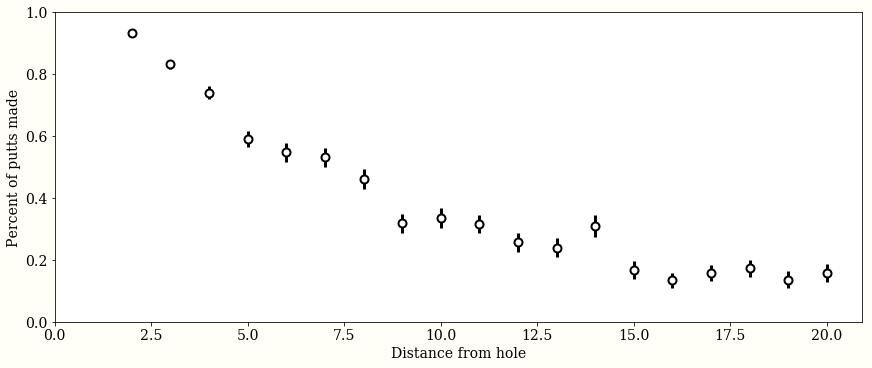

In [4]:
def plot_golf_data(golf_data, ax=None):
    """Utility function to standardize a pretty plotting of the golf data.
    
    When writing plotting code with matplotlib, it is a good idea to return 
    axes, so that they can be further customized.
    """
    if ax is None:
        _, ax = plt.subplots()
    bg_color = ax.get_facecolor()
    rv = st.beta(golf_data.successes, golf_data.tries - golf_data.successes)
    ax.vlines(golf_data.distance, *rv.interval(0.68), label=None)
    ax.plot(golf_data.distance, golf_data.successes / golf_data.tries, 'o', mfc=bg_color, label=None)

    ax.set_xlabel("Distance from hole")
    ax.set_ylabel("Percent of putts made")
    ax.set_ylim(bottom=0, top=1)
    
    ax.set_xlim(left=0)
    return ax

ax = plot_golf_data(golf_data);

After plotting, we see that generally golfers are less accurate from further away. Note that this data is pre-aggregated: we may be able to do more interesting work with granular putt-by-putt data. This data set appears to have been binned to the nearest foot. 

1. What are some questions we might want to answer with this data set?
2. Suppose we could predict the probability of a putt going in from anywhere. What could we do with that information?
3. What are some other pieces of data we might be interested in, if we could go back and design the data collection process?

## Logit model

First we will fit a traditional logit-binomial model. We model the probability of success directly, with

$$
\operatorname{logit}^{-1}(x) = \frac{e^x}{1 + e^{x}} \\
a, b \sim \mathcal{N}(0, 1) \\
p(\text{success}) = \operatorname{logit}^{-1}(a \cdot \text{distance} + b) \\ 
\text{num. successes} \sim \operatorname{Binomial}(\text{tries}, p(\text{success}))
$$

Here is how to write that model in PyMC3.

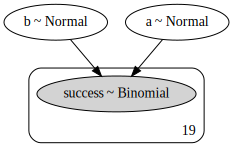

In [5]:
def logit_model(golf_data):
    with pm.Model() as logit_binomial:
        a = pm.Normal('a')
        b = pm.Normal('b')

        success = pm.Binomial('success', 
                              n=golf_data.tries, 
                              p=pm.math.invlogit(a * golf_data.distance + b), 
                              observed=golf_data.successes)
    return logit_binomial


pm.model_to_graphviz(logit_model(golf_data))

We have some intuition that $a$ should be negative, and also that $b$ should be positive (since when $\text{distance} = 0$, we expect to make nearly 100% of putts). We are not putting that into the model, though. We are using this as a baseline, and we may as well wait and see if we need to add stronger priors.

In [6]:
with logit_model(golf_data):
    logit_trace = pm.sample(1000, tune=1000)
pm.summary(logit_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:04<00:00, 1749.66draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.255,0.006,-0.267,-0.243,0.000,0.000,1045.0,1040.0,1055.0,1398.0,1.00
b,2.225,0.057,2.121,2.339,0.002,0.001,1107.0,1103.0,1133.0,1298.0,1.01


We see $a$ and $b$ have the signs we expected. There were (probably) no warnings emitted from the sampler. Looking at the summary, the number of effective samples is reasonable, and the rhat is close to 1. This is a small model, so we are not being too careful about inspecting the fit.

First we plot 50 values of $a$ and $b$ in the logit model, as well as the expected value of the two:

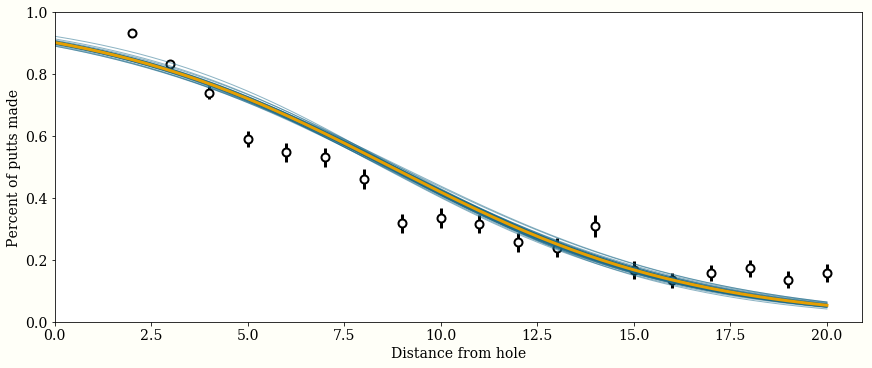

In [7]:
ax = plot_golf_data(golf_data)
t = np.linspace(0, golf_data.distance.max(), 200)

for idx in np.random.randint(0, len(logit_trace), 50):
    ax.plot(t, scipy.special.expit(logit_trace['a'][idx] * t + logit_trace['b'][idx]), lw=1, color='C1', alpha=0.5)
ax.plot(t, scipy.special.expit(logit_trace['a'].mean() * t + logit_trace['b'].mean()), color='C2');

The fit is ok, but not great! It is a good start for a baseline, and lets us answer curve-fitting type questions. 

One thing we might wonder is how the curve can be so far away from the observed data points. There is actually extra modelled noise around that curve. We can visualize that using the `sample_posterior_predictive` method.

/home/colin/projects/pymc3/pymc3/sampling.py:1134: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn("samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:00<00:00, 694.80it/s]


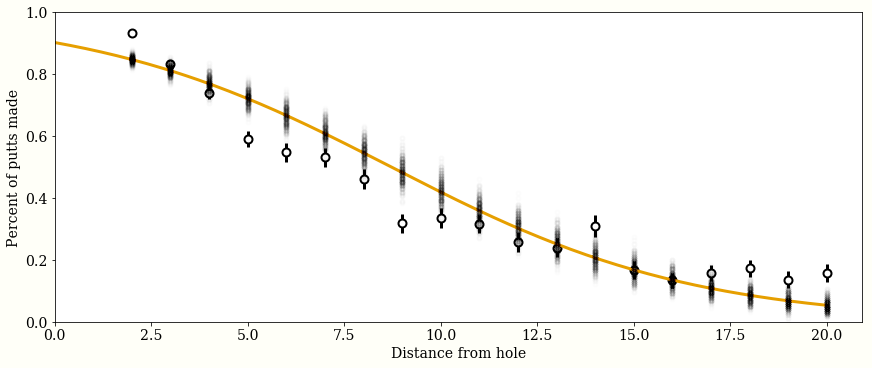

In [8]:
with logit_model(golf_data):
    # hard to plot more than 500 sensibly
    logit_ppc = pm.sample_posterior_predictive(logit_trace, samples=500)

    
ax = plot_golf_data(golf_data)
logit_ppc_success = logit_ppc['success'].T / golf_data.tries.values.reshape(-1, 1)
t = np.linspace(0, golf_data.distance.max(), 200)
ax.plot(t, scipy.special.expit(logit_trace['a'].mean() * t + logit_trace['b'].mean()), color='C2')
ax.plot(golf_data.distance, logit_ppc_success, 'k.', alpha=0.01);

An interesting thing to note about Bayesian regression models is that you can get strong correlations between coefficients. This makes many variational fitting strategies (like ADVI) which ignore such correlations dangerous to use:

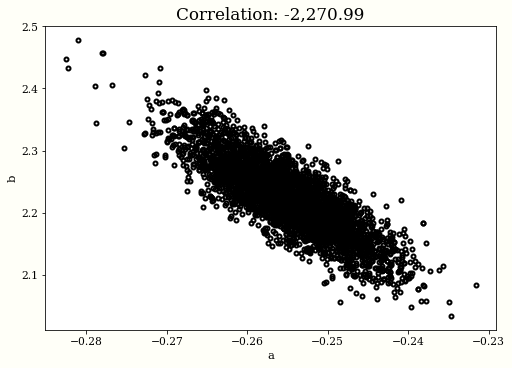

In [9]:
ax = pm.plot_pair(logit_trace, figsize=(7, 5));

corr = np.correlate(logit_trace['a'], logit_trace['b'])[0]
ax.set_title(f"Correlation: {corr:,.2f}");

## Geometry-based model

As a second pass at modelling this data, we think about the geometry of the situation. We suppose professional golfers can hit the ball in a certain direction, with some small error. Specifically, the angle the ball actually travels is normally distributed around 0, with some variance that we will try to learn.

Then the ball goes in whenever the error in angle is small enough that the ball still hits the cup. This is intuitively nice! A longer putt will admit a smaller error in angle, and so a lower success rate than for shorter putts.

I am skipping a derivation of the probability of making a putt given the accuracy variance and distance to the hole, but it is a fun exercise in geometry, and turns out to be

$$
p(\text{success} | \sigma_{\text{angle}}, \text{distance}) = 2 \Phi\left( \frac{ \arcsin (R - r) / \text{distance}}{\sigma_{\text{angle}}}\right),
$$

where $\Phi$ is the normal cumulative density function, $R$ is the radius of the cup, and $r$ is the radius of the golf ball.

To get a feeling for this model, let's look at a few manually plotted values for $\sigma_{\text{angle}}$.

In [10]:
BALL_RADIUS = (1.68 / 2) / 12
CUP_RADIUS = (4.25 / 2) / 12

def forward_angle_model(variance_of_shot, t):
    return 2 * st.norm(0, variance_of_shot).cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t)) - 1

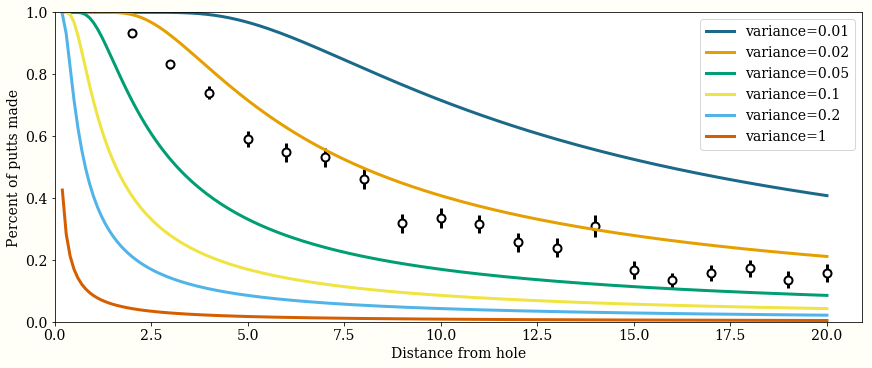

In [11]:
ax = plot_golf_data(golf_data)

t = np.linspace(0, golf_data.distance.max(), 200)

for variance_of_shot in (0.01, 0.02, 0.05, 0.1, 0.2, 1):
    ax.plot(t, forward_angle_model(variance_of_shot, t), label=f"variance={variance_of_shot}")
ax.legend();

A few things to think about here:

1. Around what would you expect a reasonable value for $\sigma_{\text{angle}}$ will be?
2. If you are advising a professional golfer, how might this help?
3. What are some other physical parameters you might want to add to the model?

### Fitting the model

PyMC3 has $\Phi$ implemented, but it is pretty hidden (`pm.distributions.dist_math.normal_lcdf`), and it is worthwhile to implement it ourselves anyways, using an identity with the [error function](https://en.wikipedia.org/wiki/Error_function).

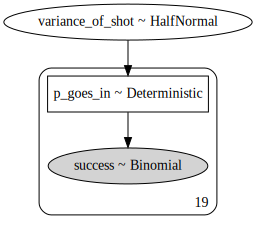

In [12]:
import theano.tensor as tt

def Phi(x):
    """Calculates the standard normal cumulative distribution function.
    """
    return 0.5 + 0.5 * tt.erf(x / tt.sqrt(2.))

def angle_model(golf_data):
    with pm.Model() as angle_model:
        variance_of_shot = pm.HalfNormal('variance_of_shot')
        p_goes_in = pm.Deterministic('p_goes_in', 2 * Phi(tt.arcsin((CUP_RADIUS - BALL_RADIUS) / golf_data.distance) / variance_of_shot) - 1)
        success = pm.Binomial('success', n=golf_data.tries, p=p_goes_in, observed=golf_data.successes)
    return angle_model

pm.model_to_graphviz(angle_model(golf_data))

### Prior Predictive Checks

We often wish to sample from the prior, especially if we have some idea of what the observations would look like, but not a lot of intuition for the prior parameters. We have an angle-based model here, but it might not be intuitive if the *variance* of the angle is given, how that effects the accuracy of a shot. Let's check!

In [13]:
with angle_model(golf_data):
    angle_prior = pm.sample_prior_predictive(500)

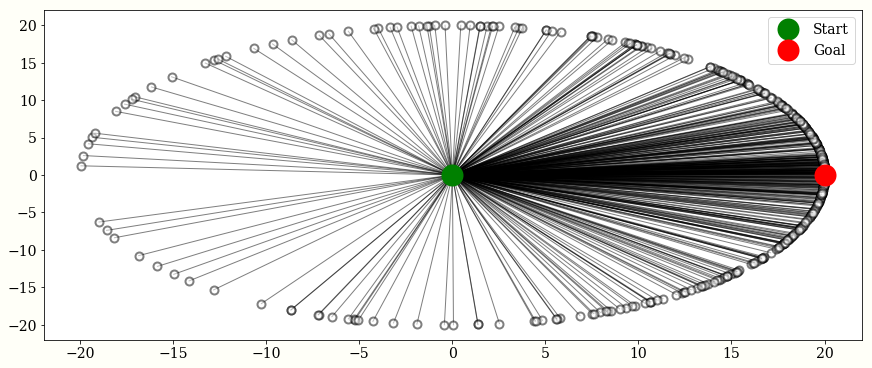

In [14]:
angle_of_shot = np.random.normal(0, angle_prior['variance_of_shot'])  # radians
distance = 20 # feet

end_positions = np.array([
    distance * np.cos(angle_of_shot),
    distance * np.sin(angle_of_shot)
])

fig, ax = plt.subplots()
for endx, endy in end_positions.T:
    ax.plot([0, endx], [0, endy], 'k-o', lw=1, mfc='w', alpha=0.5);
ax.plot(0, 0, 'go', label='Start', mfc='g', ms=20)
ax.plot(distance, 0, 'ro', label='Goal', mfc='r', ms=20)

ax.legend();

### Exercises

1. What are some things that are funny about this prior?
2. What are some things that are funny about this model?
3. Why might the Von Mises distribution be appropriate here? What might be hard about using a Von Mises instead of a Normal for the angle? Why might we be justified in using a Normal instead?

In [15]:
with angle_model(golf_data):
    angle_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [variance_of_shot]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2294.90draws/s]


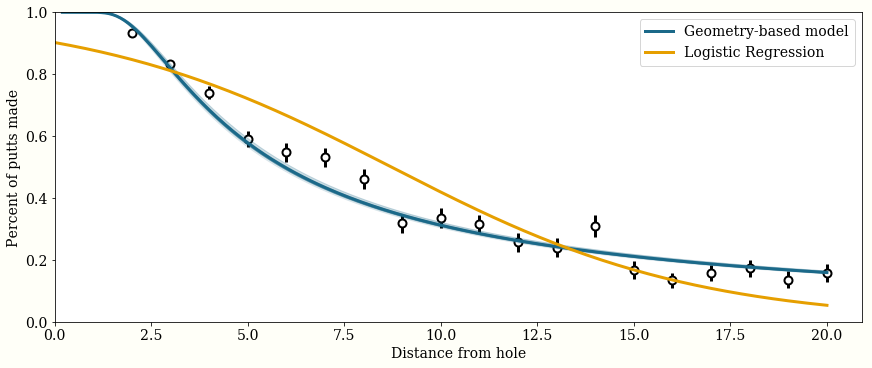

In [16]:
ax = plot_golf_data(golf_data)

t = np.linspace(0, golf_data.distance.max(), 200)

for idx in np.random.randint(0, len(angle_trace), 50):
    ax.plot(t, forward_angle_model(angle_trace['variance_of_shot'][idx], t), lw=1, color='C1', alpha=0.1)
ax.plot(t, forward_angle_model(angle_trace['variance_of_shot'].mean(), t), label='Geometry-based model')

ax.plot(t, scipy.special.expit(logit_trace['a'].mean() * t + logit_trace['b'].mean()), label='Logistic Regression')
ax.legend();

### Exercises

1. Check the summary of the fit using `pm.summary`, making sure $\hat{R}$ is near 1, and the effective sample size is at least 1,000.
1. Plot some points from the posterior predictive distribution on the above plot. 
1. Remake the plot we used for the prior predictive distribution using posterior samples of `variance_of_shot`. Does it seem reasonable to not have bound the prior between $-\pi$ and $\pi$?

## New Data!

Mark Broadie used new summary data on putting to fit a new model. We will use this new data to refine our model



In [17]:
#  golf putting data from Broadie (2018)
new_golf_data = """distance tries successes
0.28 45198 45183
0.97 183020 182899
1.93 169503 168594
2.92 113094 108953
3.93 73855 64740
4.94 53659 41106
5.94 42991 28205
6.95 37050 21334
7.95 33275 16615
8.95 30836 13503
9.95 28637 11060
10.95 26239 9032
11.95 24636 7687
12.95 22876 6432
14.43 41267 9813
16.43 35712 7196
18.44 31573 5290
20.44 28280 4086
21.95 13238 1642
24.39 46570 4767
28.40 38422 2980
32.39 31641 1996
36.39 25604 1327
40.37 20366 834
44.38 15977 559
48.37 11770 311
52.36 8708 231
57.25 8878 204
63.23 5492 103
69.18 3087 35
75.19 1742 24"""

new_golf_data = pd.read_csv(io.StringIO(new_golf_data), sep=" ")

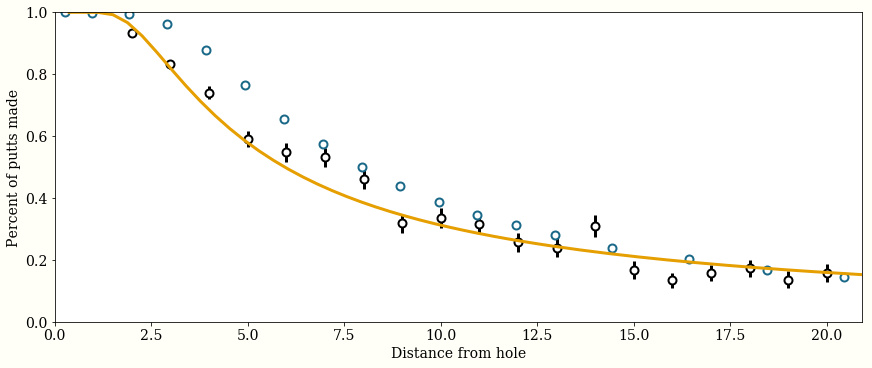

In [18]:
ax = plot_golf_data(golf_data)
plot_golf_data(new_golf_data, ax=ax)
t = np.linspace(0, new_golf_data.distance.max(), 200)

ax.plot(t, forward_angle_model(angle_trace['variance_of_shot'].mean(), t));

### Exercises

1. How many putts are in this data set compared to the old data set?
2. Do the two data sets seem to be saying the same thing? How might you explain the differences?

## Fitting the model on the new data

This goes (typically!) worse than earlier: there are divergences, and it takes much longer to run. This may indicate a problem with the model: Gelman calls this the "folk theorem of statistical computing".

In [19]:
with angle_model(new_golf_data):
    new_angle_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [variance_of_shot]
Sampling 4 chains, 1,019 divergences: 100%|██████████| 8000/8000 [03:02<00:00,  7.21draws/s] 
There were 507 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 511 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


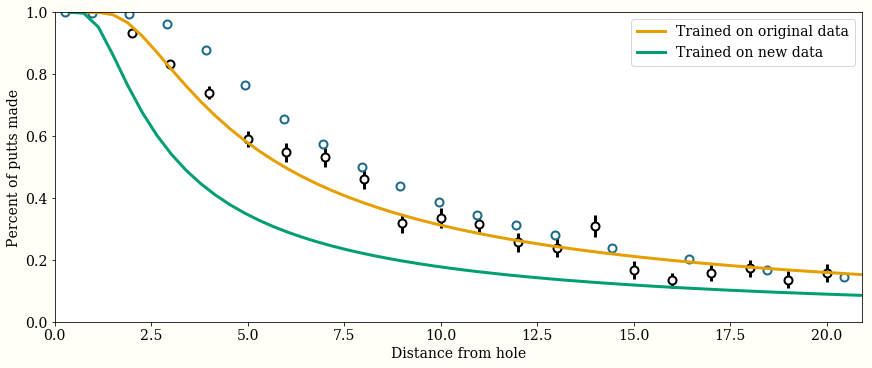

In [20]:
ax = plot_golf_data(golf_data)
plot_golf_data(new_golf_data, ax=ax)
t = np.linspace(0, new_golf_data.distance.max(), 200)

ax.plot(t, forward_angle_model(angle_trace['variance_of_shot'].mean(), t), label='Trained on original data')
ax.plot(t, forward_angle_model(new_angle_trace['variance_of_shot'].mean(), t), label='Trained on new data')
ax.legend();

## A model incorporating distance to hole

We might assume that, in addition to putting in the right direction, a golfer may need to hit the ball the right distance. Specifically, we assume:

1. If a put goes short *or* more than 3 inches past the hole, it will not go in.
2. Golfers aim for 1 inch past the hole
3. The distance the ball goes, $u$, is distributed according to
$$
u \sim \mathcal{N}\left(1 + \text{distance}, \sigma_{\text{distance}} (1 + \text{distance})\right),
$$
where we will learn $\sigma_{\text{distance}}$.

Again, this is a geometry and algebra problem to work the probability that the ball goes in from any given distance: 
$$
P(\text{good distance}) = P(\text{distance} < u < \text{distance} + 3)
$$

it uses `Phi`, the cumulative normal density function we implemented earlier.

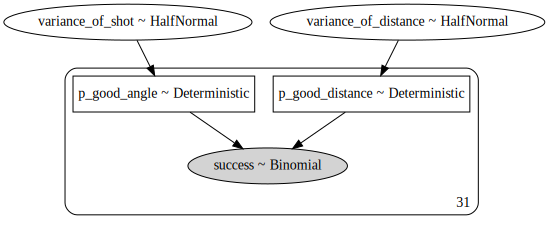

In [21]:
OVERSHOT = 1.0
DISTANCE_TOLERANCE = 3.0

def distance_angle_model(golf_data):
    distances = golf_data.distance.values
    with pm.Model() as distance_angle_model:
        variance_of_shot = pm.HalfNormal('variance_of_shot')
        variance_of_distance = pm.HalfNormal('variance_of_distance')
        p_good_angle = pm.Deterministic('p_good_angle', 2 * Phi(tt.arcsin((CUP_RADIUS - BALL_RADIUS) / distances) / variance_of_shot) - 1)
        p_good_distance = pm.Deterministic('p_good_distance', Phi((DISTANCE_TOLERANCE - OVERSHOT) / ((distances + OVERSHOT) * variance_of_distance)) - 
                                                              Phi(-OVERSHOT / ((distances + OVERSHOT) * variance_of_distance)))

        success = pm.Binomial('success', n=golf_data.tries, p=p_good_angle * p_good_distance, observed=golf_data.successes)
    return distance_angle_model

pm.model_to_graphviz(distance_angle_model(new_golf_data))

### Exercises

1. How many dimensions does this model have? How many did the previous model have?
1. Is `OVERSHOT` and `DISTANCE_TOLERANCE` reasonable to you? How might you check?
1. The `variance_of_distance` and `variance_of_shot` have no explicit correlation. If we added a prior that they were positively correlated, what does that intuitively mean? How would you add such a correlation structure?

## Fitting the distance angle model

In [22]:
with distance_angle_model(new_golf_data):
    distance_angle_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [variance_of_distance, variance_of_shot]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:06<00:00, 1231.02draws/s]


In [23]:
def forward_distance_angle_model(variance_of_shot, variance_of_distance, t):
    rv = st.norm(0, 1)
    angle_prob = 2 * rv.cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t) / variance_of_shot) - 1
    
    distance_prob_one = rv.cdf((DISTANCE_TOLERANCE - OVERSHOT) / ((t + OVERSHOT) * variance_of_distance))
    distance_prob_two = rv.cdf(-OVERSHOT / ((t + OVERSHOT) * variance_of_distance))
    distance_prob = distance_prob_one - distance_prob_two
    
    return angle_prob * distance_prob

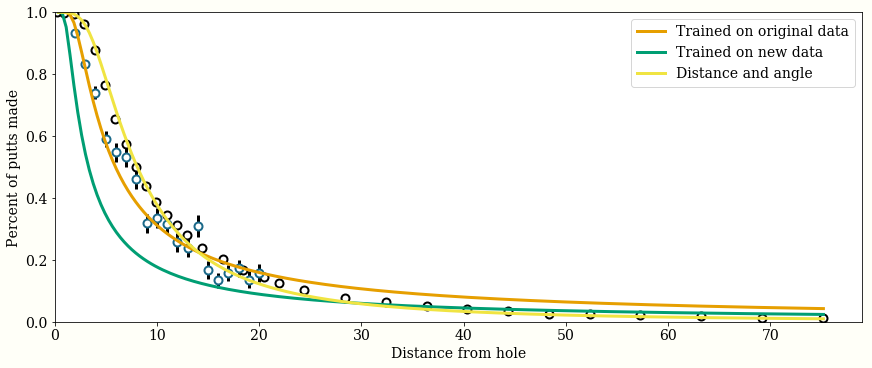

In [24]:
ax = plot_golf_data(new_golf_data)
plot_golf_data(golf_data, ax=ax)
t = np.linspace(0, new_golf_data.distance.max(), 200)


ax.plot(t, forward_angle_model(angle_trace['variance_of_shot'].mean(), t), label='Trained on original data')
ax.plot(t, forward_angle_model(new_angle_trace['variance_of_shot'].mean(), t), label='Trained on new data')
ax.plot(t, forward_distance_angle_model(distance_angle_trace['variance_of_shot'].mean(), distance_angle_trace['variance_of_distance'].mean(), t), label="Distance and angle")

ax.legend();

### Exercises

1. Which line did we just fit?
2. This plot is pretty busy. Can we remove everything except the new dataset and the most recently fit line?

## Posterior predictive checks

Now that we have sampled parameters, we can use `PyMC3` to sample observations from the posterior distribution. This can be compared to prediction in traditional machine learning. We can look at the accuracy the model predicts at various distances compared to actual accuracy, and perhaps use that to improve the model if there are systematic or obvious errors.

In [25]:
with distance_angle_model(new_golf_data):
    ppc = pm.sample_posterior_predictive(distance_angle_trace)

100%|██████████| 4000/4000 [00:06<00:00, 649.54it/s]


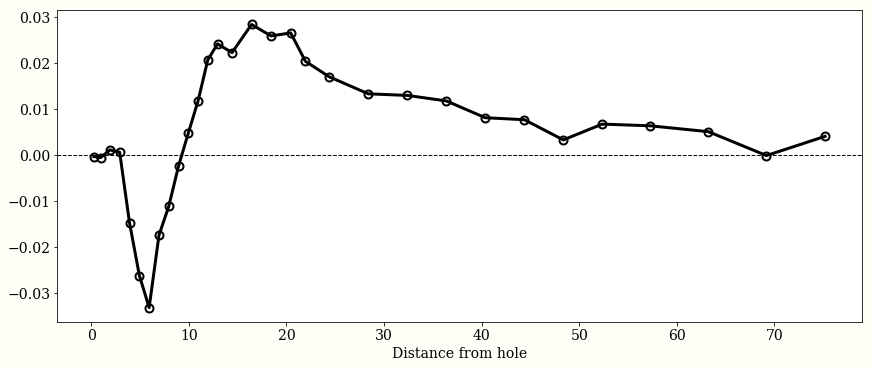

In [26]:
residuals = (new_golf_data.successes - ppc['success'].mean(axis=0)) / new_golf_data.tries

fig, ax = plt.subplots()

ax.plot(new_golf_data.distance, residuals, 'o-')
ax.axhline(y=0, linestyle='dashed', linewidth=1)
ax.set_xlabel("Distance from hole");

In [27]:
## Takes ~6 minutes to run, and does not go well.
# with logit_model(new_golf_data):
#     new_logit_trace = pm.sample(1000, tune=1000)

In [28]:
pm.compare({
    "distance_angle": distance_angle_trace, 
    "angle": new_angle_trace, 
#     'logit': new_logit_trace,
})

/home/colin/projects/arviz/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
distance_angle,0,3174.81,195.897,0,1,494.451,0,True,deviance
angle,1,1.03309e+06,324241,1.02991e+06,0,482157,479274,True,deviance


### Exercises

1. From the residual plot, which distances are most accurate? What percent of observations come from those distances?
2. The comparison table suggests you ignore the angle formula in favor of this new distance_angle formula (using the `weight` column). What happens if you fit the `distance_angle` model again (save to a new variable name), and add this trace *from the same model* to the comparison?

## A new model

The residuals suggested (spoilers!) that the first few observations were very accurate, and accounted for most of the model fit. This may be because of the `Binomial` likelihood, which cares deeply about these points with many observations. One thing we could do is add some independent extra error to each data point (independent of the number of observations). We could do this by 
1. The `Binomial` distribution in usually parametrized by $n$, the number of observations, and $p$, the probability of an individual success. We could instead parametrize it by mean ($np$) and variance ($np(1-p)$), and add error independent of $n$ to the likelihood.
2. Use a `BetaBinomial` distribution, though the error there would still be (roughly) proportional to the number observations
3. Approximate the Binomial with a Normal distribution of the probability of success. This is actually equivalent to the first approach, but does not require a custom distribution. Note that we will use $p$ as the mean, and $p(1-p) / n$ as the variance. Once we add some dispersion $\epsilon$, the variance becomes $p(1-p)/n + \epsilon$.

We follow approach 3, as in the Stan case study, and leave 1 as an exercise.

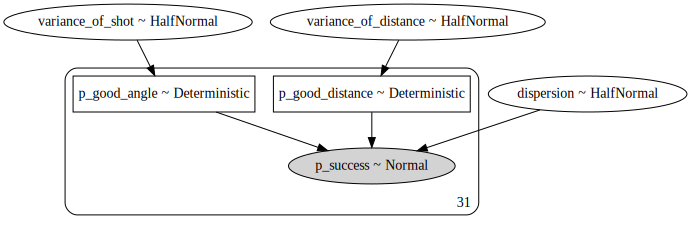

In [29]:
def disp_distance_angle_model(golf_data):
    distances = golf_data.distance.values
    with pm.Model() as distance_angle_model:
        variance_of_shot = pm.HalfNormal('variance_of_shot')
        variance_of_distance = pm.HalfNormal('variance_of_distance')
        dispersion = pm.HalfNormal('dispersion')
        
        p_good_angle = pm.Deterministic('p_good_angle', 2 * Phi(tt.arcsin((CUP_RADIUS - BALL_RADIUS) / distances) / variance_of_shot) - 1)
        p_good_distance = pm.Deterministic('p_good_distance', Phi((DISTANCE_TOLERANCE - OVERSHOT) / ((distances + OVERSHOT) * variance_of_distance)) - 
                                                              Phi(-OVERSHOT / ((distances + OVERSHOT) * variance_of_distance)))
        
        p = p_good_angle * p_good_distance
        p_success = pm.Normal('p_success', mu=p, sd=tt.sqrt(((p * (1 - p)) / golf_data.tries) + dispersion ** 2), observed=golf_data.successes / golf_data.tries)
    return distance_angle_model

pm.model_to_graphviz(disp_distance_angle_model(new_golf_data))

In [30]:
with disp_distance_angle_model(new_golf_data):
    disp_distance_angle_trace = pm.sample(1000, tune=1000)
    disp_ppc = pm.sample_posterior_predictive(disp_distance_angle_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dispersion, variance_of_distance, variance_of_shot]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:09<00:00, 840.36draws/s] 
The acceptance probability does not match the target. It is 0.8835356154215473, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 4000/4000 [00:11<00:00, 333.35it/s]


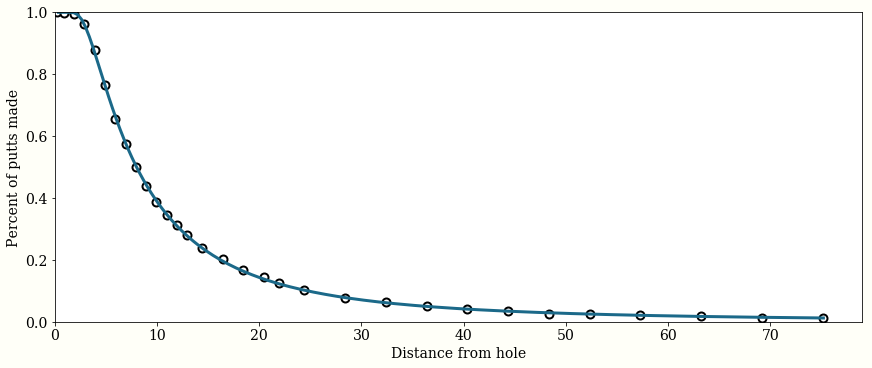

In [31]:
ax = plot_golf_data(new_golf_data)
t = np.linspace(0, new_golf_data.distance.max(), 200)

ax.plot(t, forward_distance_angle_model(disp_distance_angle_trace['variance_of_shot'].mean(), disp_distance_angle_trace['variance_of_distance'].mean(), t));

### Exercises

1. We use `dispersion ** 2` in the likelihood to follow Gelman's example. What changes if we use just `dispersion`?
1. Are we overfitting? What does that even mean in this case?

## Check residuals and score the model

We plot this new model against all our older models. As a sanity check, you might make sure you can pick out which line is the newest model.

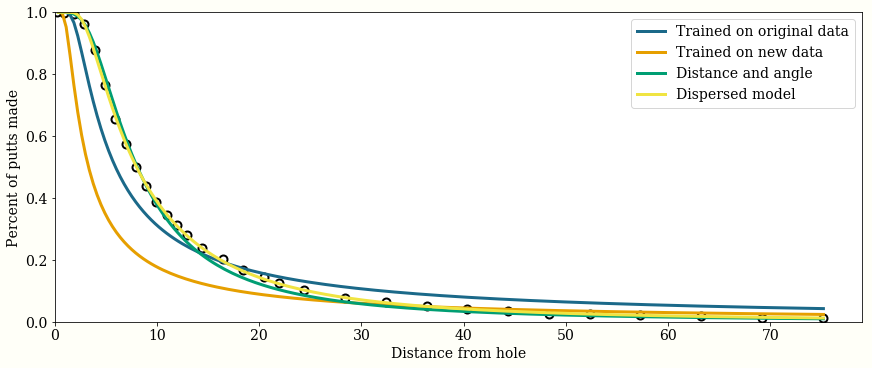

In [32]:
ax = plot_golf_data(new_golf_data, ax=None)
t = np.linspace(0, new_golf_data.distance.max(), 200)


ax.plot(t, forward_angle_model(angle_trace['variance_of_shot'].mean(), t), label='Trained on original data')
ax.plot(t, forward_angle_model(new_angle_trace['variance_of_shot'].mean(), t), label='Trained on new data')
ax.plot(t, forward_distance_angle_model(distance_angle_trace['variance_of_shot'].mean(), distance_angle_trace['variance_of_distance'].mean(), t), label="Distance and angle")
ax.plot(t, forward_distance_angle_model(disp_distance_angle_trace['variance_of_shot'].mean(), disp_distance_angle_trace['variance_of_distance'].mean(), t), label="Dispersed model")

ax.legend();

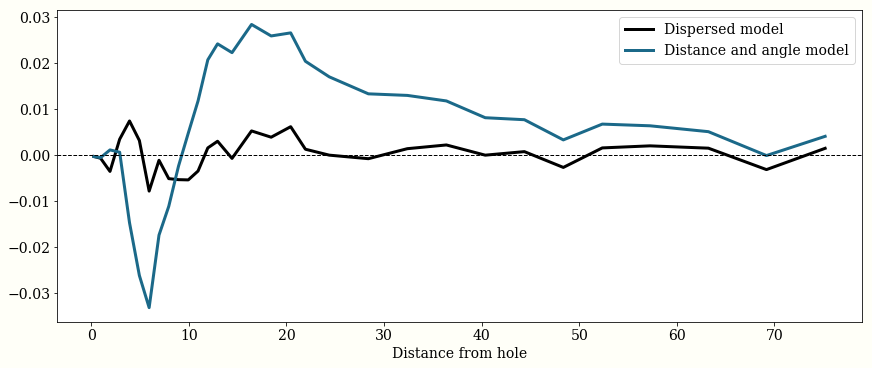

In [33]:
old_residuals = (new_golf_data.successes - ppc['success'].mean(axis=0)) / new_golf_data.tries

residuals = new_golf_data.successes / new_golf_data.tries - disp_ppc['p_success'].mean(axis=0)

fig, ax = plt.subplots()

ax.plot(new_golf_data.distance, residuals, label='Dispersed model')
ax.plot(new_golf_data.distance, old_residuals, label='Distance and angle model')
ax.legend()
ax.axhline(y=0, linestyle='dashed', linewidth=1)
ax.set_xlabel("Distance from hole");

In [34]:
pm.compare({
    "distance_angle": distance_angle_trace, 
    "angle": new_angle_trace, 
#     'logit': new_logit_trace, 
    'dispersed': disp_distance_angle_trace,
})

/home/colin/projects/arviz/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
dispersed,0,-255.468,4.61473,0,1,471437,0,True,deviance
distance_angle,1,3174.81,195.897,3430.27,0,8.95979,511.936,True,deviance
angle,2,1.03309e+06,324241,1.03334e+06,0,496.775,479264,True,deviance


### Exercises

1. Approximately how long did each model take to train on the new data (the progressbars might help with this)? With the same amount of data, is there an easy way to guess how long a model will take to sample from?
1. Looking at the residuals, is the new model strictly better than the old model? When might we prefer one to the other?
1. Our likelihood is normally distributed around the probability of making a putt for this model, and a binomial distribution around the number of putts made in the two previous models. Is the `compare` output meaningful in this case?

## Additional Visualizations

To emphasize that these are simulations, we can try to visualize how 10,000 putts from a pro golfer might look. In a first version of these plots, I used the mean of the `variance_of_shot` and `variance_of_distance` to just sample angles and distances from a normal distribution. This is a bad approach! *Since we conditioned on how many putts were actually made, these two variables are correlated*. Instead we will:

1. Set the number of simulations to 10,000
2. Draw 10,000 random *joint* samples from `variance_of_shot` and `variance_of_distance`
3. For each of those, draw an angle and a distance from normal distributions
4. Plot the point, unless it would have gone in the hole

In [35]:
distance_to_hole = 50
trials = 10_000
n_samples = disp_distance_angle_trace['variance_of_shot'].shape[0]

idxs = np.random.randint(0, n_samples, trials)
variance_of_shot = disp_distance_angle_trace['variance_of_shot'][idxs]
variance_of_distance = disp_distance_angle_trace['variance_of_distance'][idxs]

theta = np.random.normal(0, variance_of_shot)
distance = np.random.normal(distance_to_hole + OVERSHOT, (distance_to_hole + OVERSHOT) * variance_of_distance)

final_position = np.array([distance * np.cos(theta), distance * np.sin(theta)])

made_it = np.abs(theta) < np.arcsin((CUP_RADIUS - BALL_RADIUS) / distance_to_hole)
made_it = made_it * (final_position[0] > distance_to_hole) * (final_position[0] < distance_to_hole + DISTANCE_TOLERANCE)



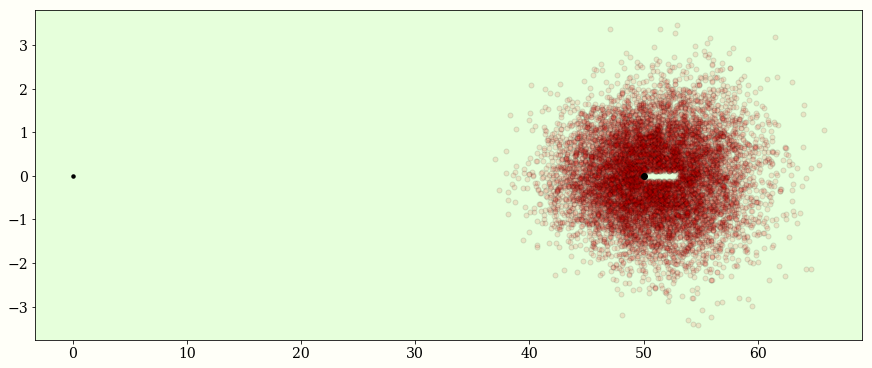

In [36]:
fig, ax = plt.subplots()

ax.plot(0, 0, 'k.', lw=1, mfc='black', ms=5)
ax.plot(*final_position[:, ~made_it], 'o', alpha=0.1, mfc='r', ms=5, mew=1)
ax.plot(distance_to_hole, 0, 'ko', lw=1, mfc='black', ms=5)

ax.set_facecolor("#e6ffdb");

In [37]:
distance_to_hole = 7
trials = 10_000
n_samples = disp_distance_angle_trace['variance_of_shot'].shape[0]

idxs = np.random.randint(0, n_samples, trials)
variance_of_shot = disp_distance_angle_trace['variance_of_shot'][idxs]
variance_of_distance = disp_distance_angle_trace['variance_of_distance'][idxs]

theta = np.random.normal(0, variance_of_shot, trials)
distance = np.random.normal(distance_to_hole + OVERSHOT, (distance_to_hole + OVERSHOT) * variance_of_distance, trials)

final_position = np.array([distance * np.cos(theta), distance * np.sin(theta)])

made_it = np.abs(theta) < np.arcsin((CUP_RADIUS - BALL_RADIUS) / distance_to_hole)
made_it = made_it * (final_position[0] > distance_to_hole) * (final_position[0] < distance_to_hole + DISTANCE_TOLERANCE)


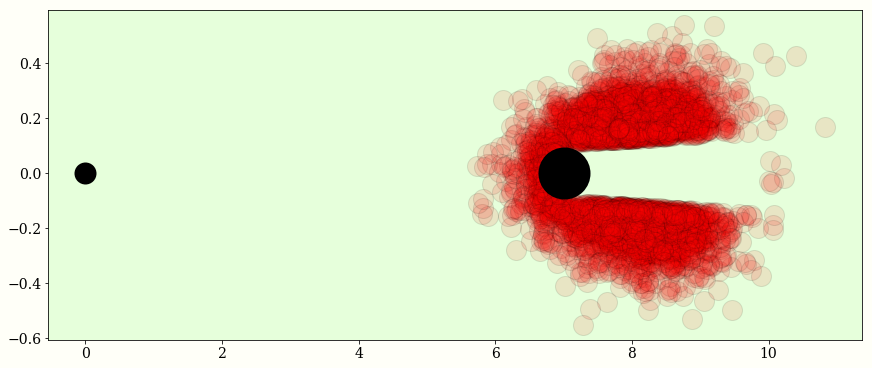

In [38]:
fig, ax = plt.subplots()

ax.plot(0, 0, 'k.', lw=1, mfc='black', ms=40)
ax.plot(*final_position[:, ~made_it], 'o', alpha=0.1, mfc='r', ms=20, mew=1)
ax.plot(distance_to_hole, 0, 'ko', lw=1, mfc='black', ms=50)

ax.set_facecolor("#e6ffdb");